# ND2 File Processing Pipeline for Max Intensity Projections

This notebook processes multi-dimensional ND2 microscopy files to create maximum intensity 
projections along the Z-axis for each timepoint. The pipeline is designed for time-lapse 
fluorescence microscopy data with multiple channels.

Key Features:
- Loads ND2 files containing multi-channel, multi-timepoint, Z-stack data
- Performs contrast enhancement for better visualization
- Creates maximum intensity projections along the Z-axis
- Saves processed images as multi-page TIF files

File Structure Expected:
- Dimensions: Time (T) x Z-stack (Z) x Channels (C) x Y x X
- Channel 0: Fluorescence channel (used for max projection)
- Channel 1: Brightfield channel (reference)

## Imports

In [ ]:
from nd2reader import ND2Reader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
import os

## Configuration

In [ ]:
# Define working directories
WORKING_DIR = r'D:\David\endoderm_migration\raw_data\zm060325_C21R11_day2To3_twoChamb_SDF1_Left'
RAW_DATA_DIR = r'Z:\1. Nikon confocal\Zohar\zm060325_C21R11_day2To3_twoChamb_SDF1_Left'

# Create output directory for max intensity projections
MAX_INTENSITY_OUTPUT_DIR = os.path.join(WORKING_DIR, 'max_intensity_projections')
os.makedirs(MAX_INTENSITY_OUTPUT_DIR, exist_ok=True)

## Helper Functions

In [ ]:
def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8), percentile_clip=(1, 99)):
    """
    Enhance image contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    with robust normalization to prevent extreme value bias.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Input grayscale image
    clip_limit : float
        Threshold for contrast limiting in CLAHE (default: 2.0)
    tile_grid_size : tuple
        Size of grid for histogram equalization (default: (8, 8))
    percentile_clip : tuple
        Lower and upper percentiles for normalization to remove outliers (default: (1, 99))
    
    Returns:
    --------
    numpy.ndarray
        Contrast-enhanced 8-bit image
    """
    # Convert to float for safe manipulation
    image_float = image.astype(np.float32)
    
    # Compute percentile-based clipping to remove extreme values
    low_percentile, high_percentile = percentile_clip
    low_val = np.percentile(image_float, low_percentile)
    high_val = np.percentile(image_float, high_percentile)
    
    # Clip image values to the computed percentile range
    image_clipped = np.clip(image_float, low_val, high_val)
    
    # Normalize to 0-255 range
    if high_val > low_val:
        image_normalized = ((image_clipped - low_val) / (high_val - low_val) * 255).astype(np.uint8)
    else:
        image_normalized = np.zeros_like(image_clipped, dtype=np.uint8)
    
    # Handle color images by converting to grayscale if needed
    if len(image_normalized.shape) == 3:
        if image_normalized.shape[2] == 3:
            image_normalized = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2GRAY)
        elif image_normalized.shape[2] == 4:
            image_normalized = cv2.cvtColor(image_normalized, cv2.COLOR_BGRA2GRAY)
    
    # Create and apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(image_normalized)
    
    return enhanced_image

# STEP 1: EXPLORE ND2 FILE STRUCTURE

ND2 dimensions: {'x': 7834, 'y': 2304, 'c': 2, 't': 74, 'z': 9}


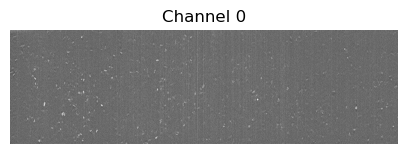

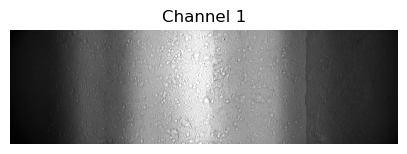

In [ ]:
print("=" * 70)
print("STEP 1: Exploring ND2 File Structure")
print("=" * 70)

# Select first ND2 file for exploration
sample_file = os.path.join(RAW_DATA_DIR, 'zm060325_c21r11_day2to3_twochamb_sdf1_left_xy1.nd2')

print(f"\nSample file: {os.path.basename(sample_file)}")
print("-" * 50)

# View the dimensions and display sample images from each channel
with ND2Reader(sample_file) as nd2:
    print(f"File dimensions: {nd2.sizes}")
    print(f"  - Time points (t): {nd2.sizes.get('t', 1)}")
    print(f"  - Z-slices (z): {nd2.sizes.get('z', 1)}")
    print(f"  - Channels (c): {nd2.sizes.get('c', 1)}")
    print(f"  - Image size: {nd2.sizes.get('y', 0)} x {nd2.sizes.get('x', 0)} pixels")
    
    # Display a sample frame from each channel
    print("\nDisplaying sample frames from each channel (t=0, z=0):")
    
    for channel_idx in range(nd2.sizes['c']):
        plt.figure(figsize=(6, 6))
        
        # Get frame from first timepoint and first z-slice
        image = nd2.get_frame_2D(c=channel_idx, t=0, z=0)
        
        # Enhance contrast for better visualization
        enhanced_image = enhance_contrast(image)
        
        # Display
        plt.imshow(enhanced_image, cmap='gray')
        plt.axis('off')
        plt.title(f"Channel {channel_idx} {'(Fluorescence)' if channel_idx == 0 else '(Brightfield)'}")
        plt.show()

# STEP 2: CREATE MAX INTENSITY PROJECTIONS

In [ ]:
print("\n" + "=" * 70)
print("STEP 2: Creating Maximum Intensity Projections")
print("=" * 70)
print("\nProcessing all ND2 files in the directory...")
print("-" * 50)

# Process all ND2 files in the directory
nd2_files = [f for f in os.listdir(RAW_DATA_DIR) if f.endswith('.nd2')]
print(f"Found {len(nd2_files)} ND2 files to process")

for file_idx, filename in enumerate(nd2_files, 1):
    print(f"\n[{file_idx}/{len(nd2_files)}] Processing: {filename}")
    
    # Full path to the ND2 file
    nd2_filepath = os.path.join(RAW_DATA_DIR, filename)
    
    try:
        with ND2Reader(nd2_filepath) as nd2:
            # Set iteration order for consistency
            nd2.iter_axes = 'tzcyx'
            
            # Verify that channel 0 (fluorescence) exists
            if 'c' not in nd2.sizes or nd2.sizes['c'] < 1:
                print(f"  ⚠️  Skipping - No channels found")
                continue
            
            print(f"  - Dimensions: T={nd2.sizes['t']}, Z={nd2.sizes['z']}, C={nd2.sizes['c']}")
            
            # Create max projections for each timepoint
            max_projections = []
            
            for t in range(nd2.sizes['t']):
                # Collect all z-slices for current timepoint (channel 0 = fluorescence)
                z_stack = []
                for z in range(nd2.sizes['z']):
                    frame = nd2.get_frame_2D(c=0, t=t, z=z)
                    z_stack.append(frame)
                
                # Convert to numpy array and compute max projection
                z_stack = np.array(z_stack)
                max_projection = np.max(z_stack, axis=0)
                
                # Enhance contrast for better visualization
                max_projection_enhanced = enhance_contrast(
                    max_projection, 
                    clip_limit=2.0, 
                    tile_grid_size=(8, 8), 
                    percentile_clip=(1, 99)
                )
                
                max_projections.append(max_projection_enhanced)
            
            # Save as multi-page TIF file
            output_filename = filename.replace('.nd2', '_max_projection.tif')
            output_filepath = os.path.join(MAX_INTENSITY_OUTPUT_DIR, output_filename)
            
            # Stack all timepoints and save
            max_projection_stack = np.stack(max_projections, axis=0)
            imwrite(output_filepath, max_projection_stack, imagej=True)
            
            print(f"  ✓ Saved: {output_filename}")
            print(f"    - Output shape: {max_projection_stack.shape} (T, Y, X)")
            
    except Exception as e:
        print(f"  ❌ Error processing {filename}: {str(e)}")
        continue

# STEP 3: OPTIONAL - EXTRACT BRIGHTFIELD FRAMES

In [ ]:
print("\n" + "=" * 70)
print("STEP 3: Optional - Brightfield Frame Extraction")
print("=" * 70)
print("\nExample code for extracting brightfield frames (commented out):")
print("-" * 50)

print("""
# Uncomment and modify this code to extract brightfield frames if needed:

# with ND2Reader(sample_file) as nd2:
#     # Brightfield is typically channel 1
#     # Extract brightfield frames at specific intervals
#     
#     brightfield_frames = []
#     
#     # Example: Get brightfield at every 5th timepoint, middle z-slice
#     for t in range(0, nd2.sizes['t'], 5):  # Every 5th frame
#         z_middle = nd2.sizes['z'] // 2      # Middle z-slice
#         frame = nd2.get_frame_2D(c=1, t=t, z=z_middle)
#         
#         # Enhance contrast
#         frame_enhanced = enhance_contrast(frame)
#         brightfield_frames.append(frame_enhanced)
#     
#     # Save brightfield stack
#     if brightfield_frames:
#         brightfield_stack = np.stack(brightfield_frames)
#         output_path = sample_file.replace('.nd2', '_brightfield_timelapse.tif')
#         imwrite(output_path, brightfield_stack)
""")

# SUMMARY

In [ ]:
print("\n" + "=" * 70)
print("PROCESSING COMPLETE")
print("=" * 70)
print(f"\nOutput directory: {MAX_INTENSITY_OUTPUT_DIR}")
print(f"Processed files: {len(nd2_files)}")
print("\nMax projection files are saved as multi-page TIF files,")
print("where each page represents a different timepoint.")
print("\nThese files can be opened in ImageJ/Fiji for further analysis.")